# Поисково-Рекомендательная система фильмов

Идея проекта – создать телеграмм бот для рекомендаций фильмов пользователям.
Рекомендации будут выволдиться на основе оценок пользователей.
Телеграм-бот будет включать модуль поиска фильма по вольному описанию пользователя. Такой модуль поможет уменьшить проблему "холодного старта" рекомендательной системы.

Суть данного модуля: пользователь вводит запрос, запрос превращается в эмбеддинг и сравнивается с эмбеддингами из датасета. С помощью косинусного сходства находятся наиболее похожие вектора описаний фильмов из датасета и пользователю выдается названия фильмов с описанием наиболее похожих к запросу пользователя.  

В этом ноутбуке показана работа с данными и первичная обработка.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 1. Работа с данными



In [2]:
import pandas as pd
import numpy as np
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf


In [3]:
#Функция для загрузки данных
def load_movie_data (p_file_path):

    f = open(p_file_path)

    add_rows ={}
    index = 0
    for line in f:
        attributes = line.replace('\n', '').split(' ::: ')

        if len (attributes) < 4:
            continue

        add_rows[index] = {'id': attributes[0],
                           'title': attributes[1],
                           'genre': attributes[2],
                           'description': attributes[3]}

        index = index + 1

    f.close()

    return pd.DataFrame.from_dict(add_rows, "index")



In [5]:
data = load_movie_data ('/content/drive/MyDrive/Colab Notebooks/REC_SYS/train_data.txt')

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 0 to 54213
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  object
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


In [6]:
data.head()

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...


In [7]:
data.shape

(54214, 4)

In [8]:
#Видим, что в колонке 'title' после названия указывает год выпуска в скобочках.
#Сделаем отдельный столбец с годом выпуска фильма

df = pd.DataFrame(data)

df['year'] = df['title'].str.extract(r'\((\d{4})\)$')
df['title'] = df['title'].apply(lambda x: x.rsplit('(', 1)[0].strip())

df.head()


,id,title,genre,description,year
0,1,Oscar et la dame rose,drama,Listening in to a conversation between his doc...,2009
1,2,Cupid,thriller,A brother and sister with a past incestuous re...,1997
2,3,"Young, Wild and Wonderful",adult,As the bus empties the students for their fiel...,1980
3,4,The Secret Sin,drama,To help their unemployed father make ends meet...,1915
4,5,The Unrecovered,drama,The film's title refers not only to the un-rec...,2007


In [9]:

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 0 to 54213
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           54214 non-null  object
 1   title        54214 non-null  object
 2   genre        54214 non-null  object
 3   description  54214 non-null  object
 4   year         49867 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


In [10]:
df[df['year'].isna()].head()

,id,title,genre,description,year
9,10,Spirits,horror,Four high school students embark on a terrifyi...,NaN
25,26,The Sandman,fantasy,A wizard attempting to capture Death to bargai...,NaN
36,37,Heroin,drama,Jos wakes up in a homeless shelter in Groninge...,NaN
38,39,Stealing Stradivarius,comedy,When Artie needs money for his daughters conse...,NaN
44,45,The Wish Kin,adventure,Fourteen-year-old Colm Bell and his 11-year-ol...,NaN


Мы видим, что у данных фильмов просто не указан год, но это существующие фильмы, так как год не влияет на нашу  модель, мы можем оставить эти данные.

In [11]:
#Проверяем на дубликаты
df.duplicated().sum()

0

In [21]:
#Посмотрим количество фильмов в каждом жанре
df.groupby('genre')[['id']].count().sort_values('id', ascending=False)
df_2 = df.groupby('genre')[['id']].count().sort_values('id', ascending=False)
df_2

,id
genre,
drama,13613
documentary,13096
comedy,7447
short,5073
horror,2204
thriller,1591
action,1315
western,1032
reality-tv,884


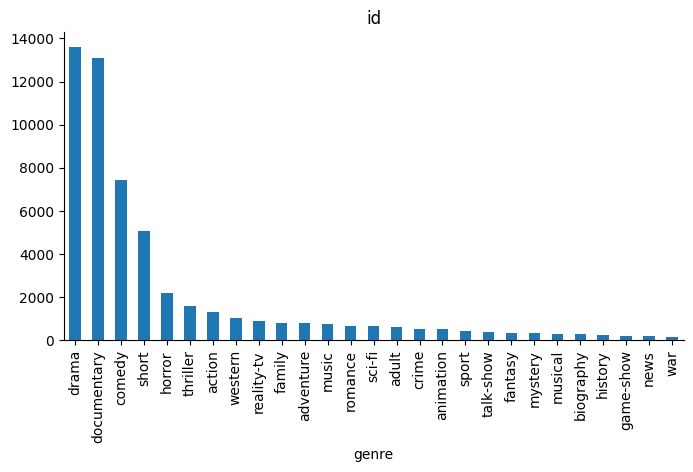

In [22]:
#Визуализация количества фильмов в каждом жанре
from matplotlib import pyplot as plt
df_2['id'].plot(kind='bar', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

Можем наблюдать, что самые популярные жанры это драма, документалка, комедия и короткометражка.

In [33]:
# Кол-во фильмов в опредленный год
df_3 = df.groupby('year')[['id']].count().sort_index(ascending = False)
df_3

,id
year,
2022,1
2021,2
2020,24
2019,82
2018,910
...,...
1898,4
1897,9
1896,3


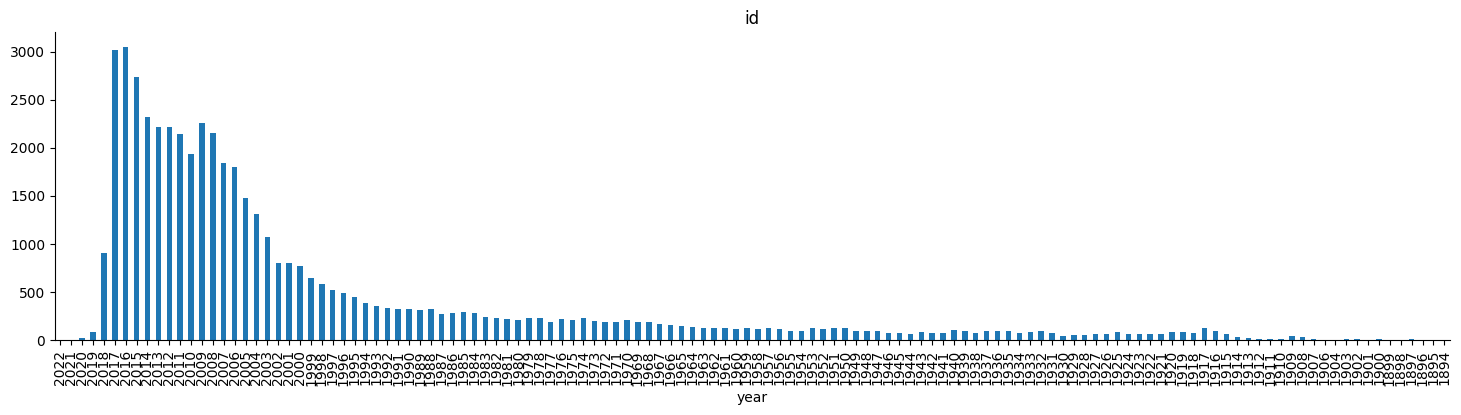

In [34]:
# Визуализация кол-ва фильмов в опредленный год
from matplotlib import pyplot as plt
df_3['id'].plot(kind='bar', figsize=(18, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

Как видно из графика, в данном датасете большинство фильмов снято после 2000 года. Но фильмы, снятые после 2019 в данный датасет не попали.


In [41]:
#Скачаем полученный нами датасет
df.to_csv('/content/drive/MyDrive/NLP/df_and_eda.csv', index=False)